In [113]:
from catenets.datasets import load
from src.iterpretability.synthetic_simulate import SyntheticSimulatorLinear
from src.iterpretability.datasets.data_loader import load
from src.iterpretability.utils import attribution_accuracy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd 

import numpy as np
from catenets.models.torch import TLearner, SLearner, TARNet, SNet
from src.iterpretability.explain import Explainer
from src.iterpretability.synthetic_experiment import PredictiveSensitivity

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from src.iterpretability.utils import (
    dataframe_line_plot,
)

In [133]:
cblind_palete = sns.color_palette("colorblind", as_cmap=True)
learner_colors = {
    "SLearner": cblind_palete[0],
    "TLearner": cblind_palete[1],
    "XLearner": cblind_palete[2],
    "TARNet": cblind_palete[3],
    "CFRNet_0.1": cblind_palete[7],
    'CFRNet_0.01': cblind_palete[4],
    "CFRNet_0.001": cblind_palete[6],
    "DRLearner": cblind_palete[8],
    "RALearner": cblind_palete[9],
    "Truth": cblind_palete[9],
}

learner_linestyles = {
    "SLearner": "-",
    "TLearner": "--",
    "XLearner": ":",
    "TARNet": "-.",
    "XLearner": "--",
    "CFRNet_0.1": "-.",
    "CFRNet_0.01": "-",
    "CFRNet_0.001": ":",
    "DRLearner": "-",
    "RALearner": "--",
    "Truth": ":",
}


learner_markers = {
    "SLearner": "d",
    "TLearner": "o",
    "XLearner": "^",
    "TARNet": "*",
    "XLearner": "D",
    "CFRNet_0.1": ">",
    "CFRNet_0.01": "8",
    "CFRNet_0.001": "s",
    "DRLearner": "x",
    "RALearner": "H",
    "Truth": "<",
}

font_size=12

def plot_results(results_df, x_axis, x_label_name, x_values_to_plot, metrics_list, learners_list): 
    fig, axs = plt.subplots(len(metrics_list), 1, figsize=(20,8))
    plt.gcf().subplots_adjust(bottom=0.15)
    
    
    for metric_id, metric in enumerate(metrics_list):
        for learner_id, learner in enumerate(learners_list):
            sub_df = results_df.loc[(results_df["Learner"] == learner)][[x_axis, metric]]

            sub_df = sub_df[sub_df[x_axis].isin(x_values_to_plot)]
            
            sub_df_mean = sub_df.groupby(x_axis).agg('mean').reset_index()
            sub_df_std = sub_df.groupby(x_axis).agg('std').reset_index()
            
            x_values = sub_df_mean.loc[:, x_axis].values
            y_values = sub_df_mean.loc[:, metric].values
            y_err = sub_df_std.loc[:, metric].values / (np.sqrt(len(seeds_list)))
            axs[metric_id].set_xscale("log")
            axs[metric_id].plot(x_values, y_values, label=learner, 
                                                      color=learner_colors[learner], linestyle=learner_linestyles[learner], marker=learner_markers[learner])
            axs[metric_id].fill_between(x_values, y_values-y_err, y_values+y_err, alpha=0.1, color=learner_colors[learner])
            axs[metric_id].set_ylabel(metric, fontsize=font_size)

    plt.rcParams['text.usetex'] = True
    axs[metric_id].set_xlabel(x_label_name, fontsize=font_size)
    plt.rcParams['text.usetex'] = False
    
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    
    #labels_map = {'target': 'Target', 'shared_source_target': 'Shared features', 'radial_gan': 'RadialGAN', 'transfer_flex': 'Transfer (ours)'}
    #new_labels = []
    #for label in labels:
    #    new_labels.append(labels_map[label])
    

    fig.legend(lines[:len(learners_list)], labels[:len(learners_list)], bbox_to_anchor=(0.9, 0.0), ncol=2, prop={'size': font_size})
    fig.tight_layout()
    plt.show()
    return fig

def plot_results_datasets(results_df_map, x_axis, x_label_name, x_values_to_plot, metrics_list, learners_list): 
    fig, axs = plt.subplots(len(metrics_list), len(results_df_map.keys()), figsize=(16,8))
    plt.gcf().subplots_adjust(bottom=0.15)
    
    for dataset_id, dataset in enumerate(results_df_map.keys()):
        results_df = results_df_map[dataset]
        for metric_id, metric in enumerate(metrics_list):
            for learner_id, learner in enumerate(learners_list):
                sub_df = results_df.loc[(results_df["Learner"] == learner)][[x_axis, metric]]

                sub_df = sub_df[sub_df[x_axis].isin(x_values_to_plot)]

                sub_df_mean = sub_df.groupby(x_axis).agg('mean').reset_index()
                sub_df_std = sub_df.groupby(x_axis).agg('std').reset_index()

                x_values = sub_df_mean.loc[:, x_axis].values
                y_values = sub_df_mean.loc[:, metric].values
                y_err = sub_df_std.loc[:, metric].values / (np.sqrt(len(seeds_list)))
                axs[metric_id][dataset_id].set_xscale("log")
                axs[metric_id][dataset_id].plot(x_values, y_values, label=learner, 
                                                          color=learner_colors[learner], linestyle=learner_linestyles[learner], marker=learner_markers[learner])
                axs[metric_id][dataset_id].fill_between(x_values, y_values-y_err, y_values+y_err, alpha=0.1, color=learner_colors[learner])
                axs[metric_id][dataset_id].set_ylabel(metric, fontsize=font_size)

        axs[0][dataset_id].set_title(dataset)
        plt.rcParams['text.usetex'] = True
        axs[metric_id][dataset_id].set_xlabel(x_label_name, fontsize=font_size)
        plt.rcParams['text.usetex'] = False
    
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    fig.legend(lines[:len(learners_list)], labels[:len(learners_list)], bbox_to_anchor=(1.0, 0.0), ncol=len(learners_list), prop={'size': font_size})
    fig.tight_layout()
    plt.show()
    return fig
    

In [139]:
def aggregate_results_and_plot_predictive_sensitivity(datasets_list, num_important_features_list, explainer, metrics_list, synthetic_simulator_type, binary_outcome, seeds_list):
    results_path = '/Users/ibica/PycharmProjects/ITErpretability/results/predictive_sensitivity'
    results_df_map = {}
    
    for dataset_id, dataset in enumerate(datasets_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"predictive_scale_{dataset}_{num_important_features_list[dataset_id]}_{synthetic_simulator_type}_random_True_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)

        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[dataset] = results_df

    fig = plot_results_datasets(results_df_map=results_df_map, x_axis='Predictive Scale', x_label_name='Predictive Scale', 
                 x_values_to_plot=[1e-3, 1e-2, 1e-1, 0.5, 1, 2], metrics_list=metrics_list,
                 learners_list=["TLearner", "SLearner", "TARNet",  "DRLearner", "XLearner", "RALearner"])
    fig.savefig("results/results_figs/" + "predictive_scale.pdf", bbox_inches="tight")
        
def aggregate_results_and_plot_nonlinearity_sensitivity(datasets_list, num_important_features_list, explainer, metrics_list, binary_outcome, seeds_list):
    results_path = '/Users/ibica/PycharmProjects/ITErpretability/results/nonlinearity_sensitivity/random'
    results_df_map = {}
    
    for dataset_id, dataset in enumerate(datasets_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"{dataset}_{num_important_features_list[dataset_id]}_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)
        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[dataset] = results_df
    
    fig = plot_results_datasets(results_df_map=results_df_map, x_axis="Nonlinearity Scale", x_label_name="Nonlinearity Scale", 
                 x_values_to_plot=[0.0, 0.2, 0.5, 0.7, 0.9, 1.0], metrics_list=metrics_list,
                 learners_list=["TLearner", "SLearner", "TARNet",  "DRLearner", "XLearner", "RALearner"])
    fig.savefig("results/results_figs/" + "nonlinearity_sensitivity.pdf", bbox_inches="tight")

    
def aggregate_results_and_plot_propensity_sensitivity(datasets_list, num_important_features_list, explainer, metrics_list, binary_outcome, propensity_type, seeds_list):
    results_path = '/Users/ibica/PycharmProjects/ITErpretability/results/propensity_sensitivity/linear'
    results_df_map = {}
    
    for dataset_id, dataset in enumerate(datasets_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"propensity_scale_{dataset}_{num_important_features_list[dataset_id]}_proptype_{propensity_type}_predscl_1.0_nonlinscl_0.5_trainratio_0.8_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)
        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[dataset] = results_df
    
    fig = plot_results_datasets(results_df_map=results_df_map, x_axis="Propensity Scale", x_label_name="Propensity Scale", 
                 x_values_to_plot=[0, 1e-1, 1, 2, 5, 10], metrics_list=metrics_list,
                 learners_list=["TLearner", "SLearner", "TARNet", "CFRNet_0.01", "CFRNet_0.001",  "CFRNet_0.1", "DRLearner", "XLearner", "RALearner"])
    fig.savefig("results/results_figs/" + "propensity_sensitivity" + "_" +  propensity_type + ".pdf", bbox_inches="tight")

# Linear + random

In [145]:
#metrics = ['All features ACC', 'Pred features ACC', 'Prog features ACC', 'PEHE', 'Normalized PEHE', 'Factual RMSE']
seeds_list = list(range(1, 30))
metrics_to_plot = ['Pred features ACC', 'Prog features ACC', 'PEHE']
explainer='integrated_gradients'
datasets_list = ['tcga_20', 'tcga_100', 'twins', 'news_100', 'acic']
num_important_features_list = [4, 20, 8, 20, 10]

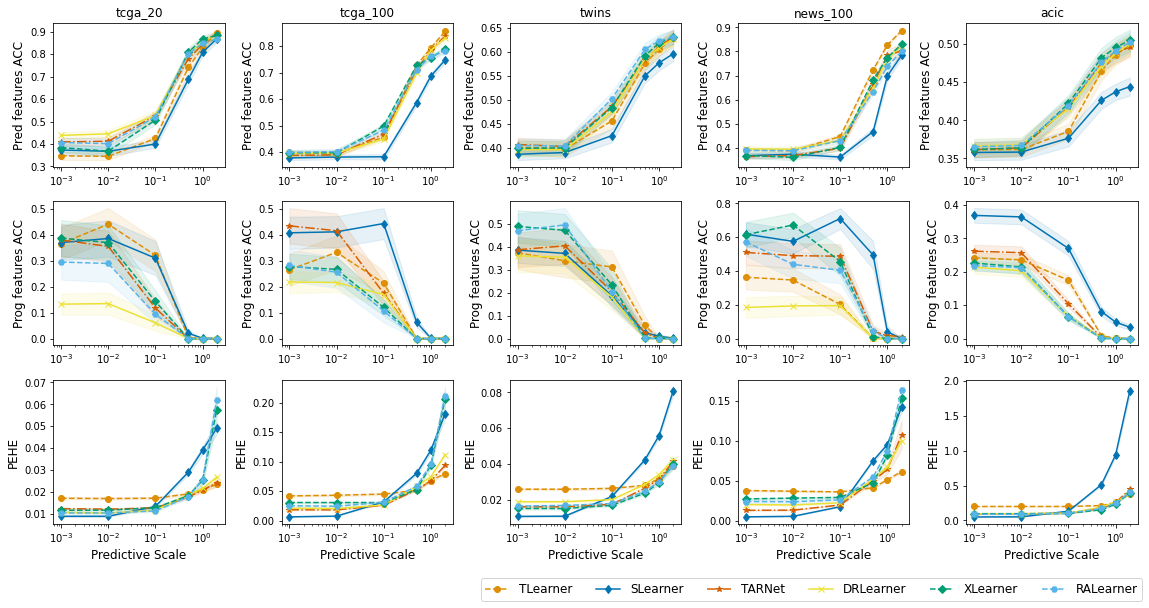

In [146]:
seeds_list = list(range(1, 30))
aggregate_results_and_plot_predictive_sensitivity(datasets_list=datasets_list, num_important_features_list=num_important_features_list, explainer=explainer, metrics_list=metrics_to_plot, synthetic_simulator_type='linear', 
                                                  binary_outcome='False', seeds_list=seeds_list)

# Non-linear sensitivity

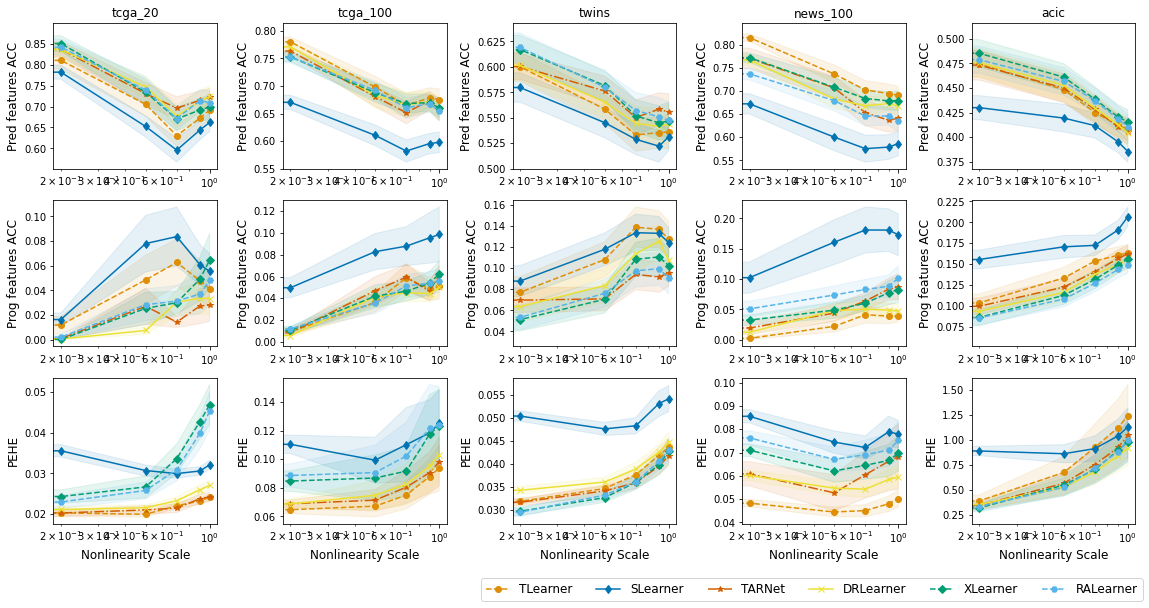

In [147]:
aggregate_results_and_plot_nonlinearity_sensitivity(datasets_list=datasets_list, num_important_features_list=num_important_features_list, explainer=explainer, metrics_list=metrics_to_plot, 
                                                  binary_outcome='False', seeds_list=seeds_list)

# Propensity sensitivity

In [143]:
propensity_type = 'irrelevant_var'
seeds_list = [1,2,3, 4, 5, 6]

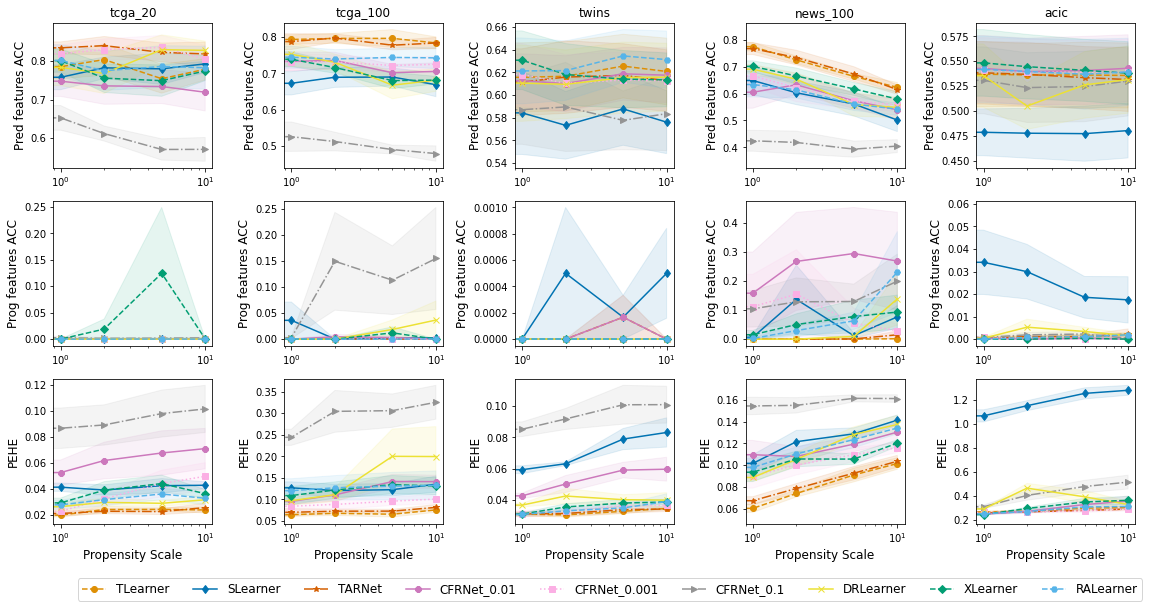

In [144]:
aggregate_results_and_plot_propensity_sensitivity(datasets_list=datasets_list, num_important_features_list=num_important_features_list, propensity_type=propensity_type, explainer=explainer, metrics_list=metrics_to_plot, 
                                                  binary_outcome='False', seeds_list=seeds_list)

# Linear + least correlated 

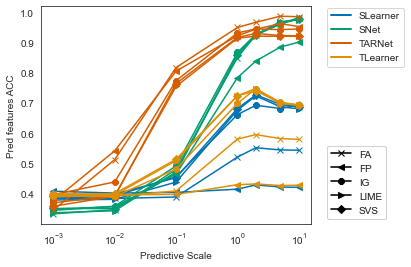

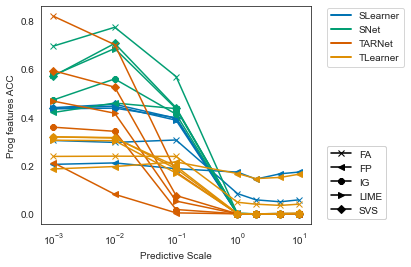

In [81]:
aggregate_results_and_plot('tcga_20', 4, 'linear', 'False', seeds_list)

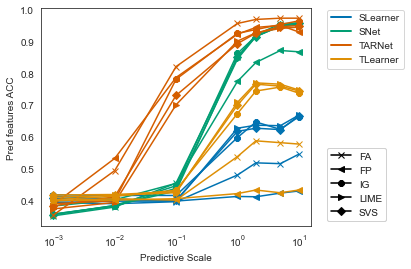

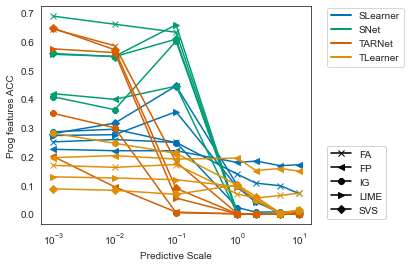

In [82]:
aggregate_results_and_plot('tcga_20', 4, 'linear_least_correlated', 'False', seeds_list)

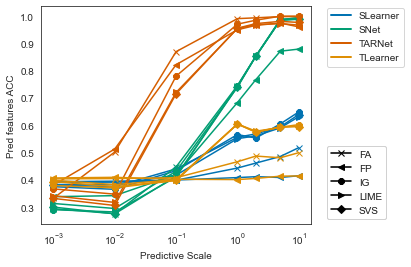

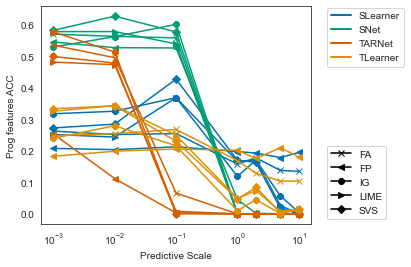

In [83]:
aggregate_results_and_plot('tcga_20', 4, 'linear_most_correlated', 'False', seeds_list)

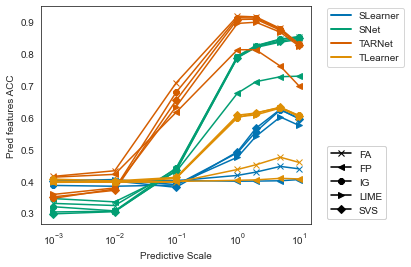

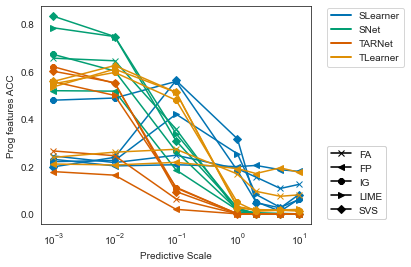

In [84]:
aggregate_results_and_plot('tcga_100', 20, 'linear', 'False', seeds_list)

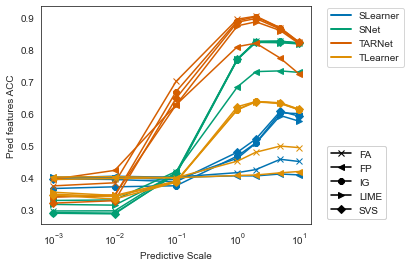

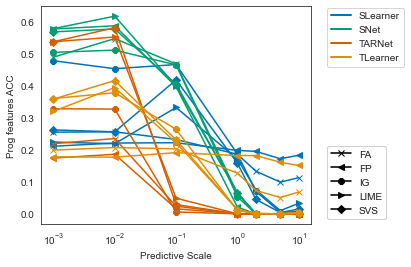

In [85]:
aggregate_results_and_plot('tcga_100', 20, 'linear_least_correlated', 'False', seeds_list)

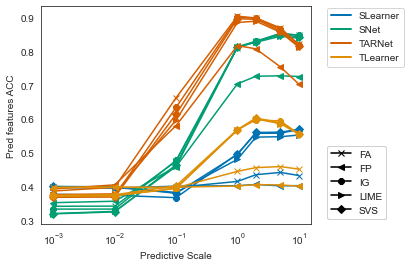

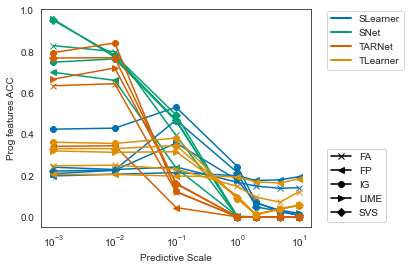

In [86]:
aggregate_results_and_plot('tcga_100', 20, 'linear_most_correlated', 'False', seeds_list)